In [95]:
import os
import numpy as np
import pandas as pd

In [96]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nfl-playoffs-19702021/df_kaggle_test.csv
/kaggle/input/nfl-playoffs-19702021/playoffs.csv
/kaggle/input/nfl-playoffs-19702021/all_games.csv
/kaggle/input/nfl-playoffs-19702021/df_kaggle_test_labels.csv
/kaggle/input/nfl-playoffs-19702021/df_kaggle_train.csv
/kaggle/input/nfl-playoffs-19702021/games_calculated_averages.csv
/kaggle/input/nfl-playoffs-19702021/1970-2021.csv
/kaggle/input/nfl-playoffs-19702021/regular_season.csv
/kaggle/input/nfl-playoffs-19702021/1970-2021_team_schedule.csv
/kaggle/input/nfl-playoffs-19702021/df_only_averages.csv
/kaggle/input/nfl-playoffs-19702021/grouped_averages.csv


---

In [97]:
from pprint import pprint
from sklearn.metrics import (
    ConfusionMatrixDisplay, 
    accuracy_score,
    balanced_accuracy_score,
    precision_score, 
    recall_score, 
    f1_score
)
from datetime import datetime

all_scores = {}

def show_scores(scores: dict = all_scores):
    display(pd.DataFrame(all_scores.values()))

def calculate_scores(
    model_name: str, 
    y_test: pd.Series, pred: np.ndarray, 
    pos_label: str or int = 1,
    score_list: list = all_scores,
    display_confusion_matrix: bool = True,
    display_scores: bool = True
    ):
    cf_mx = ConfusionMatrixDisplay.from_predictions(y_test, pred)
    acc = accuracy_score(y_test, pred)
    bacc = balanced_accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, pos_label=pos_label)
    recall = recall_score(y_test, pred, pos_label=pos_label)
    f1 = f1_score(y_test, pred, pos_label=pos_label)
    
    model_scores = {
        'model_name': model_name,
        'acc': acc,
        'bacc': bacc,
        'precision': precision,
        'recall': recall,
        'f1score': f1
    }
    score_list[model_name] = model_scores
    
    if display_confusion_matrix:
        display(cf_mx)   
    if show_scores:
        show_scores(score_list)
    return model_scores

---

# Carregamento do dataset Kaggle e preparaçao para treino e teste

In [98]:
df_kaggle_train = pd.read_csv('/kaggle/input/nfl-playoffs-19702021/df_kaggle_train.csv', sep=';')
df_kaggle_test = pd.read_csv('/kaggle/input/nfl-playoffs-19702021/df_kaggle_test.csv', sep=';')
df_kaggle_test_labels = pd.read_csv('/kaggle/input/nfl-playoffs-19702021/df_kaggle_test_labels.csv', sep=';')

In [99]:
df_kaggle_train.shape, df_kaggle_test.shape, df_kaggle_test_labels.shape

((526, 263), (52, 262), (52, 2))

In [100]:
all(df_kaggle_test['gs_id'] == df_kaggle_test_labels['gs_id'])

True

---

In [101]:
df_train = df_kaggle_train.sort_values('gs_id', ascending=True).copy()
df_train.set_index('gs_id', inplace=True)

In [102]:
df_test = df_kaggle_test.sort_values('gs_id', ascending=True).copy()
# df_test.loc[:, 'winorlose'] = df_kaggle_test_labels['winorlose']
df_test.set_index('gs_id', inplace=True)

In [103]:
df_test_labels = df_kaggle_test_labels.sort_values('gs_id', ascending=True).copy()
df_test_labels.set_index('gs_id', inplace=True)

df_test_labels = df_test_labels['winorlose'].map({'L': 0, 'W': 1})

In [104]:
df_train.shape, df_test.shape, df_test_labels.shape

((526, 262), (52, 261), (52,))

---

# Pre-processamento

In [105]:
from sklearn.model_selection import train_test_split

In [106]:
encode_target = True
corr_threshold = None
split_data = False
target = 'winorlose'

In [107]:
# bool to numeric
non_numeric_or_object = df_train.select_dtypes(exclude=[np.number, object]).columns
df_train[non_numeric_or_object] = df_train[non_numeric_or_object].astype(int)

non_numeric_or_object = df_test.select_dtypes(exclude=[np.number, object]).columns
df_test[non_numeric_or_object] = df_test[non_numeric_or_object].astype(int)

In [108]:
# cols with values that contain '%' or 'Own' to numeric
for _df in [df_train, df_test]:
    for col in _df.select_dtypes(object).columns:
        if any(_df[col].str.contains('Own', na=False)):
            _df[col] = _df[col].str.extract('[Own]?(\d+.\d*)').astype(float)
            continue
        if any(_df[col].str.contains('%', na=False)):
            _df[col] = _df[col].str.extract('(\d+.\d*)[%]').astype(float)
            continue

In [109]:
# remove columns with values that contain ':' or '-'
for _df in [df_train, df_test]:
    for col in _df.select_dtypes(object).columns:
        if any(_df[col].str.contains(':', na=False)):
            _df.drop(col, axis=1, inplace=True)
            continue
        if any(_df[col].str.contains('-', na=False)):
            _df.drop(col, axis=1, inplace=True)
            continue

In [110]:
# removing additional columns
cols_to_drop = ['gs_game_day_of_week', 'gs_game_date', 'gs_game_location', 'gs_week_number']
for _df in [df_train, df_test]:
        for _col in cols_to_drop:
            try:
                _df.drop(_col, axis=1, inplace=True)
            except KeyError as e:
                print(e)
                continue

In [111]:
# target encoding
target_encoder = {'L': 0, 'W': 1}
df_train[target] = df_train[target].map(target_encoder)

# col names
cat_cols = df_train.select_dtypes(object).columns.tolist()
num_cols = df_train.select_dtypes(np.number).columns.tolist()

In [112]:
# correlation threshold
if bool(corr_threshold) & encode_target:
    _corr = df_train[num_cols].corrwith(df_train[target])
    correlated_cols = _corr[(_corr >= corr_threshold) & (_corr != 1)].index.tolist()
else:
    correlated_cols = num_cols

In [113]:
# x & y
cols_to_use = cat_cols + correlated_cols
#     if 'gs_id' not in cols_to_use:
#         cols_to_use.append('gs_id')

if target in cols_to_use:
    cols_to_use.remove(target)

In [114]:
x_final = df_train.copy().drop(target, axis=1)
x_final = x_final[cols_to_use]
y_final = df_train[target]

df_test = df_test[cols_to_use]

In [115]:
x_final.shape, y_final.shape, df_test.shape, df_test_labels.shape

((526, 254), (526,), (52, 254), (52,))

---

# Keras

In [116]:
from tqdm.keras import TqdmCallback
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

In [117]:
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.preprocessing import RobustScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer

In [118]:
preprocess_pipeline = make_column_transformer(
    (SimpleImputer(strategy='mean', fill_value='constant'), make_column_selector(dtype_include=np.number)),
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), make_column_selector(dtype_include=object))
)

In [119]:
keras_model = Sequential()
keras_model.add(Dense(128, input_dim = x_final.shape[1], activation='relu'))

keras_model.add(Dense(256, activation='relu'))
keras_model.add(Dense(256, activation='relu'))
keras_model.add(Dense(256, activation='relu'))

keras_model.add(Dense(1, activation='sigmoid'))

keras_model.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

,model_name,acc,bacc,precision,recall,f1score
0,keras_basic,0.596154,0.577381,0.615385,0.333333,0.432432


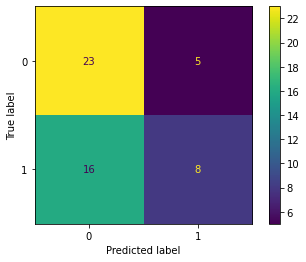

In [120]:
keras_basic = make_pipeline(
    preprocess_pipeline,
    RobustScaler(),
    keras_model
)

fit_params = {
    'sequential__epochs': 300,
    'sequential__batch_size': 32,
    'sequential__verbose': 0, 
    'sequential__callbacks': [TqdmCallback(verbose=1)]
}

keras_basic.fit(x_final, y_final, **fit_params)
_preds = keras_basic.predict(df_test)
_preds = [0 if p[0] <= 0.5 else 1 for p in _preds]  # convert to 0/1

keras_scores = calculate_scores('keras_basic', df_test_labels, _preds)

# SHAP 

In [121]:
import shap
from typing import List
import matplotlib.pyplot as plt

In [122]:
shap.initjs()

## Reconstruindo a pipeline de pré-processamento

O SHAP não gostou da pipeline do sklearn.

Aqui eu removo o modelo Keras de dentro da pipeline, deixando apenas os passos de pré-processamento.

Ai eu rodo ela separada, e depois passo os dados já pré-processados e o modelo treinado ali em cima, um de cada vez.

In [123]:
keras_preprocessing_pipeline = make_pipeline(
    preprocess_pipeline,
    RobustScaler()
)

keras_model = keras_basic.steps[-1][1]

In [124]:
x_final_preprocessed = keras_preprocessing_pipeline.fit_transform(x_final)
df_test_preprocessed = keras_preprocessing_pipeline.transform(df_test)

## "Explicador" & valores de Shapley

In [125]:
explainer = shap.DeepExplainer(keras_model, x_final_preprocessed)
shap_values = explainer.shap_values(df_test_preprocessed)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


---

## DataFrame com resultados reais x preditos

In [126]:
df_y = df_test_labels.reset_index()
df_y['predicted'] = _preds

## TP, FP, TN, FN

In [127]:
df_y['true_positive'] = (df_y['winorlose'] == 1) & (df_y['predicted'] == 1)
df_y['false_positive'] = (df_y['winorlose'] == 0) & (df_y['predicted'] == 1)
df_y['true_negative'] = (df_y['winorlose'] == 0) & (df_y['predicted'] == 0)
df_y['false_negative'] = (df_y['winorlose'] == 1) & (df_y['predicted'] == 0)

In [128]:
tp_idx = df_y[df_y['true_positive'] == True].index[0]
fp_idx = df_y[df_y['false_positive'] == True].index[0]
tn_idx = df_y[df_y['true_negative'] == True].index[0]
fn_idx = df_y[df_y['false_negative'] == True].index[0]

In [129]:
print(f'''
TP: {tp_idx}
FP: {fp_idx}
TN: {tn_idx}
FN: {fn_idx}
''')


TP: 10
FP: 12
TN: 0
FN: 1



## Gerando visualizações

In [130]:
def generate_charts(
    shap_values: List[np.ndarray],
    explainer: shap.DeepExplainer,
    idx: int,
    idx_name: str,
    feature_names: List[str],
    export_file: bool = True
) -> list:
    plots = []
    print(f'{idx_name}: {idx}')
    force_plot = shap.force_plot(
        explainer.expected_value[0].numpy(),
        shap_values[0][idx],
        features=feature_names,
        matplotlib=True
    )

    decision_plot = shap.decision_plot(
        explainer.expected_value[0].numpy(),
        shap_values[0][idx],
        features=feature_names
    )

    waterfall_plot = shap.plots._waterfall.waterfall_legacy(
        explainer.expected_value[0].numpy(),
        shap_values[0][idx],
        feature_names=feature_names
    )

    plots.append(force_plot)
    plots.append(decision_plot)
    plots.append(waterfall_plot)

    return plots

In [131]:
indexes = [tp_idx] + [fp_idx] + [tn_idx] + [fn_idx]
index_names = ['true_positive', 'false_positive', 'true_negative', 'false_negative']
feature_names = df_test.columns.to_list()

true_positive: 10


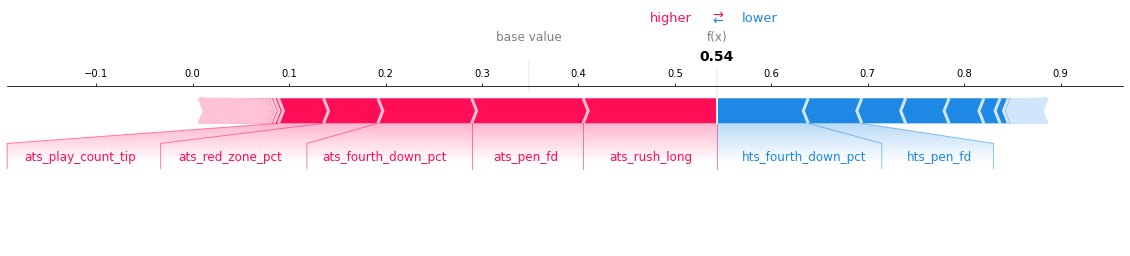

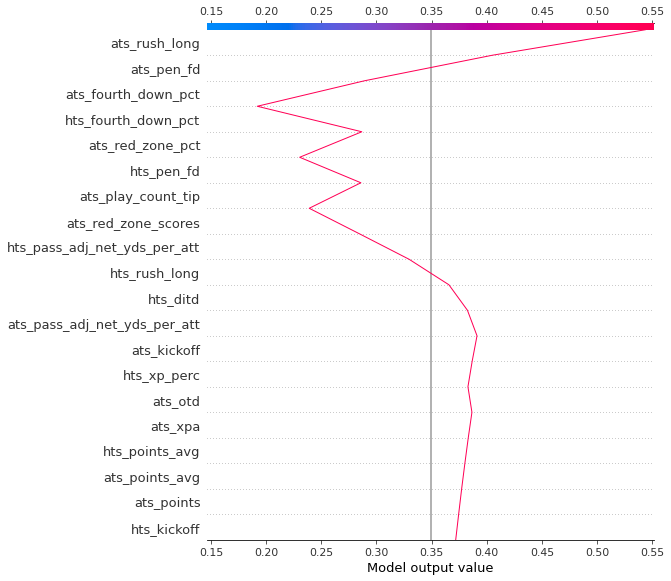

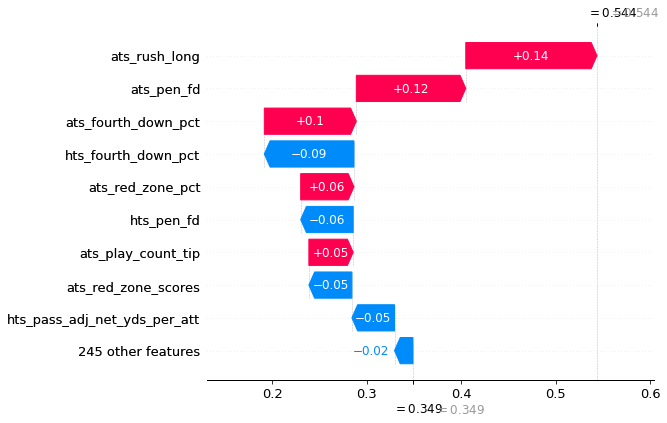

In [132]:
plots_tp = generate_charts(shap_values, explainer, indexes[0], index_names[0], feature_names)

false_positive: 12


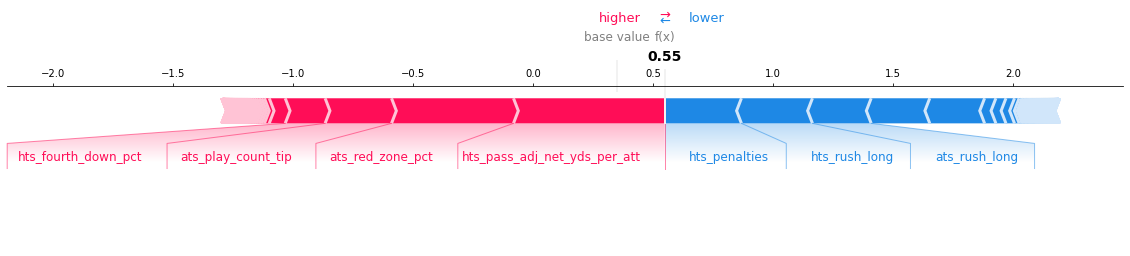

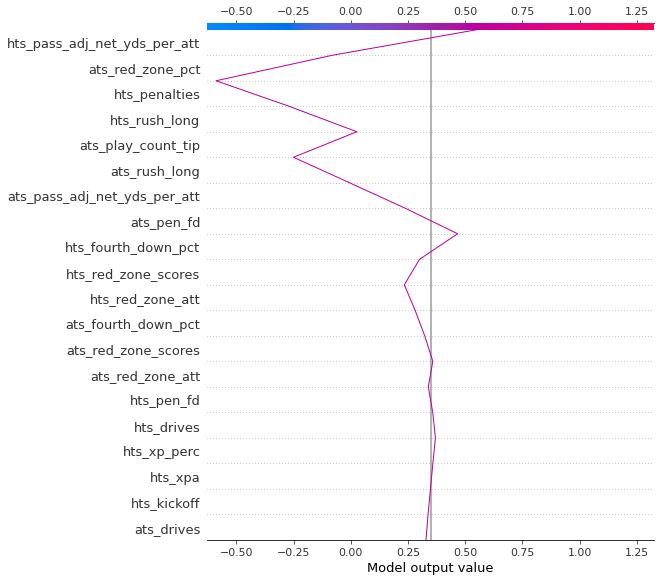

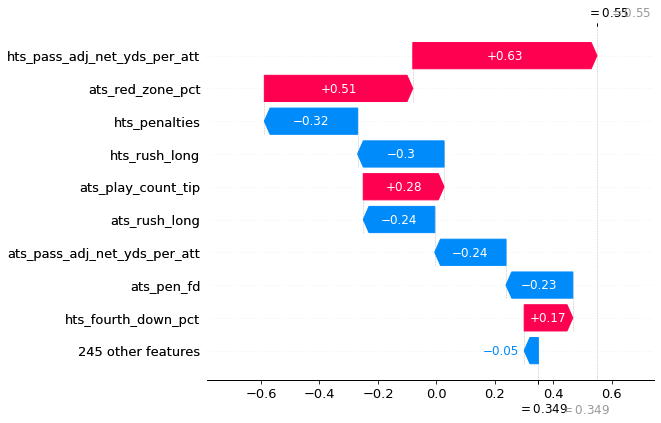

In [133]:
plots_tp = generate_charts(shap_values, explainer, indexes[1], index_names[1], feature_names)

true_negative: 0


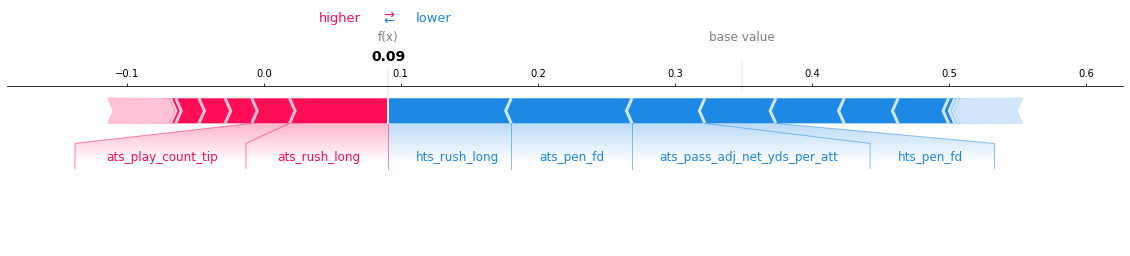

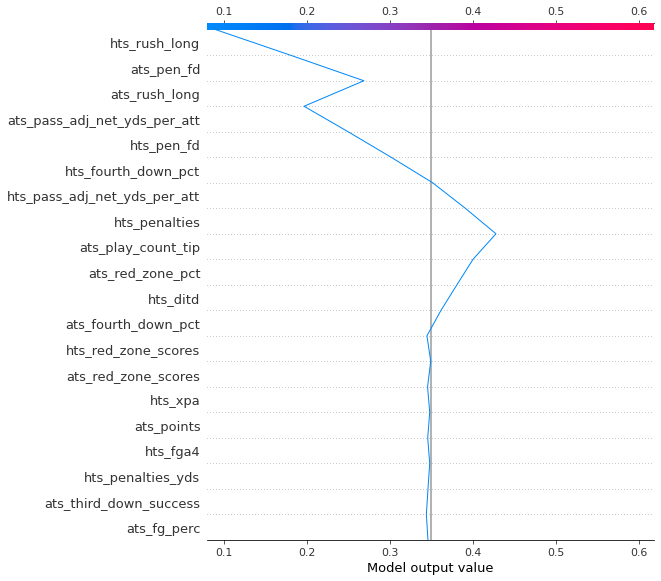

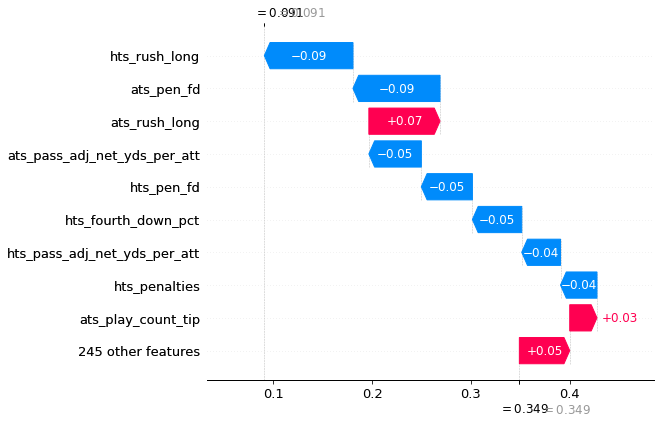

In [134]:
plots_tp = generate_charts(shap_values, explainer, indexes[2], index_names[2], feature_names)

false_negative: 1


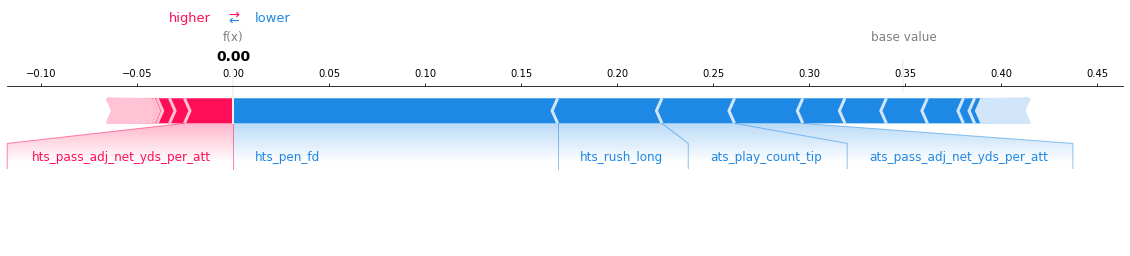

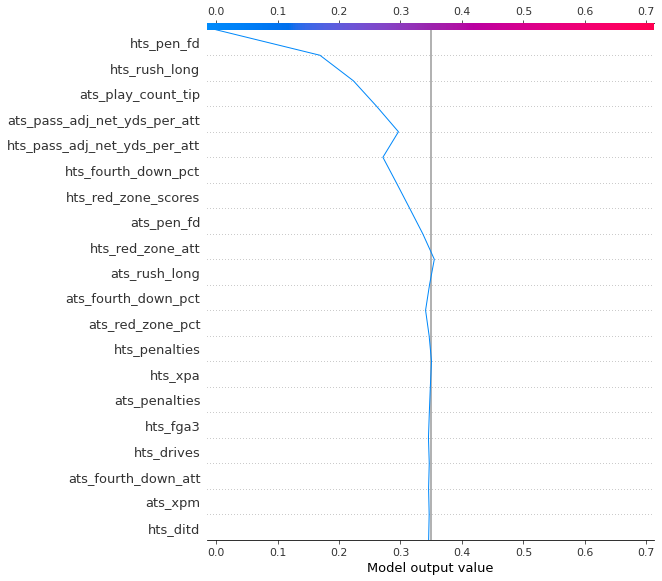

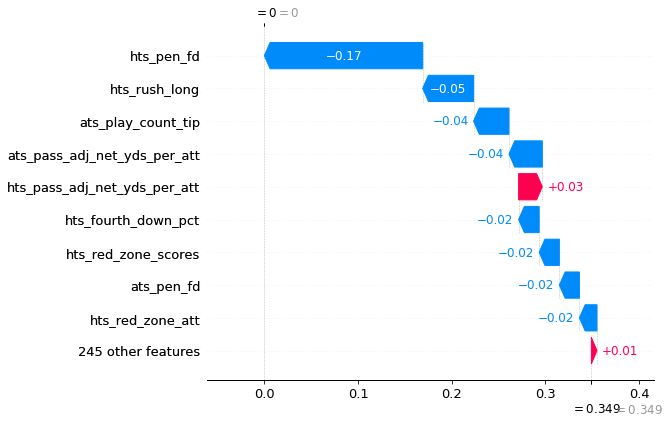

In [135]:
plots_tp = generate_charts(shap_values, explainer, indexes[3], index_names[3], feature_names)